Welcome to group C's CSCK506 Deep Learning June 2023 final assignment.

This program includes a designed CNN architecture assessed and optimised using Bayesian Hyperparameter optimisation using the training and validation datasets. These two datasets were combined and split into training and validation sets, as the validation set was composed of only 16 images and deemed insufficient for model optimisation. Finally, the program concludes by using the test dataset to assess the leading models against the original CNN architecture using accuracy, loss, precision, and ROC AUC metrics.

If accessed through Google Colab, please download the notebook and the Kaggle dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia and run on a local machine. In the submitted package, please navigate to "Program submission" and use requirements.txt to install the program dependencies needed for it to run. Additionally, the package submitted has tensorboard logs. The trained models are not included in the submission due to their size. 

The reason for this is that the free version of Google Colabs has restrictions which would have limited the development scope of the program.


### 1. Loding modules

Importing packages

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import copy
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import datetime
from PIL import Image
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import datetime

print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.10.0


Loading the pneumonia data

### 2. Load the data
The pneumonia data is split into train, val, and test files. There are only 16 files in the validation folder. Therefore, tests and validation data sets will be incorporated into the training set to mitigate the imbalance in the data set.

Assessing the number of images in training, validation and test folder

In [ ]:
train_files = tf.io.gfile.glob(str('')) #path to the training files
val_files = tf.io.gfile.glob(str('')) #path to the validation files
test_files=  tf.io.gfile.glob(str(''))#path to the test files

print(f"trainig flies: {len(train_files)}, validation flies: {len(val_files)}, test files: {len(test_files)}, total: {len(train_files)+len(val_files)+len(test_files)} ")

train_files.extend(val_files)
train_filenames, val_filenames = train_test_split(train_files, test_size=0.2)
hyper_train,hyper_val=train_test_split(train_filenames, test_size=0.2)



The following code shows the number of normal images versus those with pneumonia in the training set.

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

The following code shows the number of normal images versus those with pneumonia in the validation set.

In [ ]:
print(f"Normal images count in training set: ", len([filename for filename in val_filenames if "NORMAL" in filename]))

print(f"Pneumonia images count in training set: " , len([filename for filename in val_filenames if "PNEUMONIA" in filename]))

Creating a tensorflow data set to handle large amounts of data

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)


Run the following cell to see how many images we have in our training dataset and how many images we have in our validation set. Verify that the ratio of images is 3(pneumonia):1(normal).

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(''))]) #enter path to folder containing the classes
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

## 3 Preprocessing

3.0 Normalisation.The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down to 180x180

In [9]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
#a placeholder to allow for the visualisation of the data
epochs=32
mem=32

Rewrite the label so that 1 or True indicates pneumonia and 0 or False indicates normal.

In [10]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0

Reducing the size of the image

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path)
val_ds = val_list_ds.map(process_path)

Check that the train/validation data set has a shape of 180,180,3 and is labbeled correctly. Normal:0 , Pneumonia:1

In [ ]:
print("traing data set check")
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("The label corresponds to a " + CLASS_NAMES[label.numpy()])

print("val data set check")
for image, label in val_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("The label corresponds to a " + CLASS_NAMES[label.numpy()])


Loading test data to test_ds

In [ ]:
test_list_ds = tf.data.Dataset.from_tensor_slices(test_files)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


TEST_IMAGE_COUNT

Checking that the test data set is the same shape at the train/validation and labelled

In [ ]:
for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("The label corresponds to a " + CLASS_NAMES[label.numpy()])

Associating batch size to test_ds

In [17]:
test_ds_prepped = test_ds.batch(mem)

To understand the imbalance in the data and to address data class imbalance to manage bias

In [18]:
initial_bias =  (COUNT_PNEUMONIA/COUNT_NORMAL)
print(f"{initial_bias} in favour of pneumonia positive x-rays")

2.8114754098360657 in favour of pneumonia positive x-rays


Addressing the imbalance in the data

In [19]:
weight_for_normal = TRAIN_IMG_COUNT/(2*COUNT_NORMAL)
weight_for_pneumonia = TRAIN_IMG_COUNT/(2*COUNT_PNEUMONIA)

class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}

print('Weight for class normal: {:.2f}'.format(weight_for_normal))
print('Weight for class pneumonia: {:.2f}'.format(weight_for_pneumonia))

Weight for class normal: 1.91
Weight for class pneumonia: 0.68


Checking if data imbalance is corrected

In [ ]:
if  ((COUNT_PNEUMONIA*weight_for_pneumonia)/(COUNT_NORMAL*weight_for_normal)) == 1:
  print(True) # If the ratio is 1, then the model is balanced
else:
  print(False) # If the ratio is not 1, then the model is not balanced

3.1 Visualize the dataset
First, let's use buffered prefetching so we can yield data from disk without having I/O become blocking.

In [21]:
def prepare_for_training(ds,batchsize, cache=True, shuffle_buffer_size=1000):
    # To be used with a small data set please be cautions
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(batchsize)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [22]:
train_ds_prepped = prepare_for_training(train_ds,mem)
val_ds_prepped = prepare_for_training(val_ds,mem)



Define the method to show the images in the batch.

In [23]:
image_batch, label_batch = next(iter(train_ds_prepped))
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in numpy arrays as its parameters, call the numpy function on the batches to return the tensor in numpy array form.

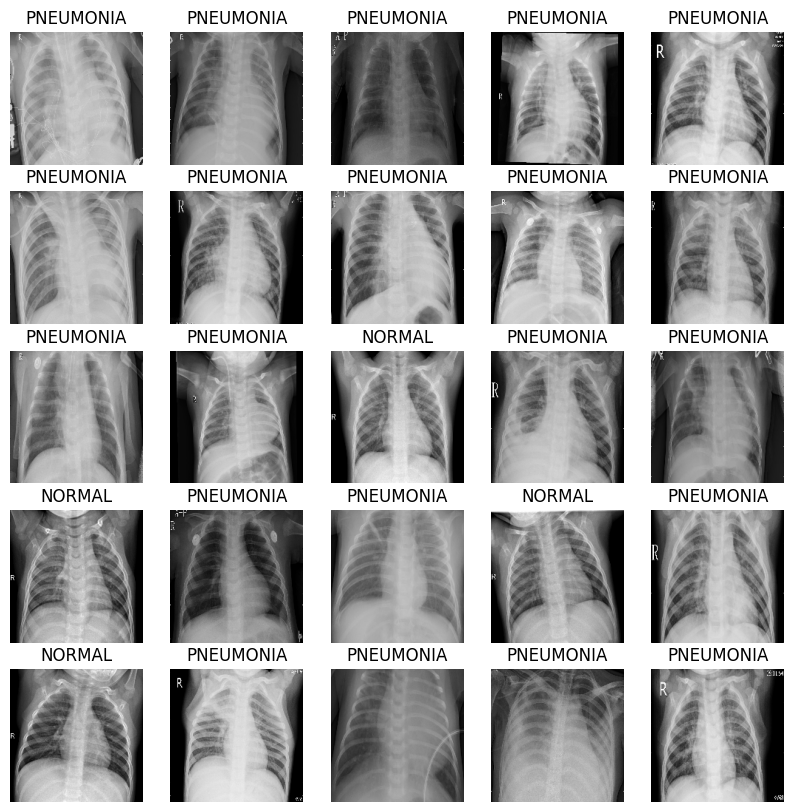

In [24]:
show_batch(image_batch.numpy(), label_batch.numpy())

3.2 Pass these arguments to the models

For testing:
*   train_ds_prepped
*   val_ds_prepped
*   epoch
*   batch_size (memory batch size set to 32 so use multiples of 2 when passing batch size to a model)
*   weight_class


For assessing:
*   test_ds_prepped
*   epoch
*   batch_size (memory batch size set to 32 so use multiples of 2 when passing batch size to a model)






## 4 Base CNN

4.0 CNN model no optimisation

In [33]:
#Building base CNN model

def base_model(prepped_train_ds,prepped_val_ds,epochs,batch_size,balancing_weights,TRAIN_IMG_COUNT,VAL_IMG_COUNT):
# Create a Sequential model
  model = Sequential()

  #CNN model layers
  #1st layer
  model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(180, 180, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.1))
  #2nd layer
  model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  #3rd layer
  model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  #4th layer
  model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  # Adding a Flatten layer
  model.add(Flatten())

  # Add fully connected layers
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  model.summary()

  # Metrics, added precision =
  metrics_call = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc')

    ]

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_call)

  history = model.fit(
      prepped_train_ds,
      steps_per_epoch=TRAIN_IMG_COUNT // batch_size,
      epochs=epochs,
      verbose = 1,
      validation_data=prepped_val_ds,
      validation_steps=VAL_IMG_COUNT // batch_size,
      class_weight=balancing_weights
  )
  return  model,history

4.1 Base CNN assessment

In [ ]:
# To run the base CNN
base_model, base_model_history = base_model(train_ds_prepped,val_ds_prepped,25,256,class_weight,TRAIN_IMG_COUNT,VAL_IMG_COUNT)

Graphing of the base CNN's train data is done in section 7.2

## 5 Hyperparamter training

5.1 Epoch and batch size selection

In [40]:
def epoch_n_batch_select(prepped_train_ds,prepped_val_ds,epochs,batch_size,class_weight,TRAIN_IMG_COUNT,VAL_IMG_COUNT):
# Create a Sequential model
  model = Sequential()

  #CNN model layers
  #1st layer
  model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(180, 180, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.1))
  #2nd layer
  model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  #3rd layer
  model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  #4th layer
  model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  # Adding a Flatten layer
  model.add(Flatten())

  # Add fully connected layers
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  model.summary()
  metrics_call = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc'),
    ]
  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_call)

 

  history=model.fit(
      prepped_train_ds,
      steps_per_epoch=TRAIN_IMG_COUNT // batch_size,
      epochs=epochs,
      verbose = 1,
      validation_data=prepped_val_ds,
      validation_steps=VAL_IMG_COUNT // batch_size,
      class_weight=class_weight,
      use_multiprocessing=True,)
 
  return history


Series seach to understand how batch size impacts accuracy and loss over epoch using training data

In [ ]:
batch_sizes=[]
batch_sizes_run={}

dfs = [] # Store dataframes here

for i, batch_size in enumerate(batch_sizes):
    history=epoch_n_batch_select(train_ds_prepped,val_ds_prepped,30,batch_size,class_weight,TRAIN_IMG_COUNT,VAL_IMG_COUNT)
    batch_sizes_run[batch_size] = history

    # Convert history to dataframe
    df = pd.DataFrame(history.history)
    df['epoch'] = df.index.values
    df['batch_size'] = batch_size
    dfs.append(df)

    # Create plot for this batch_size
    plt.figure(figsize=[15, 4])

    plt.subplot(1,2,1)
    plt.title(f'Batch Size:{batch_size} (Model Loss)')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(f'Batch Size:{batch_size} (Model Accuracy)')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

# Combine all dataframes
results_df = pd.concat(dfs, ignore_index=True)


Saving epoch and batch size assessment data 

In [42]:
df_save=df.copy()# safe to stop overwriting the original dataframe

In [43]:
df_save.to_csv(, index=False)#enter the path where you want to save the file

Result: For searching the best hyperparameters for each layer.
Chosen epoch: 30  
Batch size: 128 


5.2 Bayesian hyperparamter selection method

Hyperparameter selection model. ReLU, sigmoid and tanh activation functions were assessed individually but size of CNN layer and padding were dynamically assesed 


In [45]:
def hyperparameter_model_training(hp):
  # Create a Sequential model
  model = Sequential()

  #CNN model layers
  #1st layer
  model.add(Conv2D(hp.Choice('cnn_layer1', values=[32,64], default=32),
                     (3, 3),
                     padding= 'same',
                     # swapped with either simgoid, tanh, relu
                     activation='relu',
                     input_shape=(180, 180, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

  #2nd layer
  model.add(Conv2D(hp.Choice('cnn_layer2', values=[64,128]),
                     (3, 3),
                     padding= 'same',
                     # swapped with either simgoid, tanh, relu
                     activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

  #3rd layer
  model.add(Conv2D(hp.Choice('cnn_layer3', values=[128,256]),
                     (3, 3),
                     padding= 'same',
                     # swapped with either simgoid, tanh, relu
                     activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

  #4th layer
  model.add(Conv2D(hp.Choice('cnn_layer4', values=[256,512]),
                     (3, 3),
                     padding='same',
                     # swapped with either simgoid, tanh, relu
                     activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))


  # Adding a Flatten layer
  model.add(Flatten())
  # Add fully connected layers
  model.add(Dense(hp.Choice("dense_layer_1", values=[512,1024]), activation='relu'))# swapped with either simgoid, tanh, relu))
  model.add(Dense(1, activation='sigmoid'))

  #desired metrics
  desired_met = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc'),
    ]


  # Compile the model

  model.compile(tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-7, max_value=1e-1, sampling='LOG')), loss='binary_crossentropy', metrics=desired_met)


  return model

In [50]:
tuner = kt.BayesianOptimization(
    hyperparameter_model_training,
    objective='val_accuracy',
    max_trials=3,
    num_initial_points=2,
    seed=42,
    executions_per_trial=1,
    overwrite=True,
    directory="./hyper/tmp/tb_5"
    )

BHO uses training data

In [ ]:

# Perform the hyperparameter search
tuner.search(train_ds_prepped,
             steps_per_epoch=TRAIN_IMG_COUNT // 128, #batch size
             validation_data=val_ds_prepped,
             validation_steps=VAL_IMG_COUNT // 128, #batch size
             epochs=30,
             class_weight=class_weight,
            callbacks=[tf.keras.callbacks.TensorBoard(f"./hyper/activation/tb_logs_4"  + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))],
            )


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]




In [ ]:
# Used to get an understanding of the best model
best_model = tuner.get_best_models()[0]
best_model.summary()

Save best model which they were three one for ReLU, sigmoid and tanh activation functions

In [53]:
model = tuner.hypermodel.build(best_hps)
model.save()#enter path and entre model name here

5.3 Hyperparameter metrics

Metrics were was visualised in tensorboard to understand the data of the models and then the data was downloaded from tensorboard then complied and imported back into the note book

In [54]:
df_relu_acc = pd.read_csv('') # path to relu accuracy no padding
df_relu_loss = pd.read_csv('') # path to relu loss no padding
df_relu_acc_same = pd.read_csv('') # path to relu accuracy with padding
df_relu_loss_same = pd.read_csv('') # path to relu loss with padding
df_sigmoid_acc = pd.read_csv('')# path to sigmoid accuracy with padding
df_sigmoid_loss = pd.read_csv('') # path to sigmoid loss with padding
df_tanh_acc = pd.read_csv('') # path to tanh accuracy with no padding
df_tanh_loss = pd.read_csv('') # path to tanh loss with no padding

To plot the best models for the respective activation function

In [80]:
def hyper_plot_layer(df):

    plt.figure(figsize=[15, 4])

    # Plotting each run
    plt.plot(df['Step'], df[df.columns[1]], label='val_trial 0')
    plt.plot(df['Step'], df[df.columns[2]], label='val_trial 1')
    plt.plot(df['Step'], df[df.columns[3]], label='val_trial 2')
   

    # Labeling the axes and the plot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('tanh: validation accuracy over epoch')
    plt.legend(loc='lower right')

    plt.show()



In [ ]:
hyper_plot_layer(df_tanh_acc)

## 6. Re-train the model using training data with optimal hyperparameters obtained

In [83]:
def final_model_eval(best_hps,prepped_train_ds, prepped_val_ds,balancing_weights,epochs, batch_size,TRAIN_IMG_COUNT, VAL_IMG_COUNT):
    
    
    
    model = best_hps
    history=model.fit(
        prepped_train_ds,
      steps_per_epoch=TRAIN_IMG_COUNT // batch_size,
      epochs=epochs,
      verbose = 1,
      validation_data=prepped_val_ds,
      validation_steps=VAL_IMG_COUNT // batch_size,
      class_weight=balancing_weights
  )
        

    
    return model ,history


In [116]:
best_hps = load_model("")#used to load model from local storage

In [ ]:
final_model, final_history=final_model_eval(best_hps,train_ds_prepped, val_ds_prepped,class_weight,10,128,TRAIN_IMG_COUNT, VAL_IMG_COUNT)

6.2 To visualise performance differences between basic and optimised CNN models using training data

In [ ]:

plt.figure(figsize=[15, 4])

plt.subplot(1,2,1)
plt.title("Validation loss: base Vs optimised models")
plt.plot(final_history.history['val_loss'], label='Optimised CNN ')
plt.plot(base_model_history.history['val_loss'], label='Base CNN ')
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1,2,2)
plt.title("Validation accuracy: base Vs Optimised models")
plt.plot(final_history.history['val_accuracy'], label='Optimised CNN ')
plt.plot(base_model_history.history['val_accuracy'], label='Base CNN ')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Saving trained models

In [ ]:
# save model function
def save_model(model,name):
    model.save(f'models/trained/{name}.h5') 

In [ ]:
save_model("") # model,naming

Loading trained models

In [ ]:
baseCNN = load_model('') # path to the CNN model
optimisedCNN = load_model('') # path to the optimised CNN model
optimisedCNN2 = load_model('') # path to the optimised CNN model

### 7. Using test data to assess the optimised model

In [112]:
def labels_generator(test_ds):
  labels_list = []
  for image, label in test_ds.take(634):
    lab = label.numpy()
    labels_list.append(lab)

  return labels_list

In [ ]:
def predict_function(test_ds_prepped,test_labels,model):
    
    test_labels = labels_generator(test_ds_prepped)
    test_labels = np.concatenate(test_labels)

# Get the predicted labels and true labels for the test dataset

    
    predicted_labels = model.predict(
        test_ds_prepped,
        batch_size=20,
        verbose="auto",
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
        
    )

    #selecting 0.6 as the threshold for true
    predicted_labels = (predicted_labels>0.6)
    
    return predicted_labels

In [ ]:
predicted_labels = predict_function("") #test_ds_prepped, test_labels, model

Confusion matrix graphing of models using test dataset

In [ ]:

classification_rep = classification_report(test_labels, predicted_labels, zero_division=1)


# Print the evaluation metrics


print(classification_rep)

In [ ]:
labels = ['Pneumonia', 'Normal']

cm = confusion_matrix(test_labels, predicted_labels)

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# set x-axis label and ticks.
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)

# set plot title
ax.set_title("Confusion Matrix for Pneumonia Detection: Optimised CNN", fontsize=14, pad=20)

plt.show()


Needed for test loss, accuracy, recall, precision and ROC AUC

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_roc_auc = baseCNN.evaluate(
      test_ds_prepped,
      steps=TEST_IMAGE_COUNT // 32,
      verbose = 1,
      use_multiprocessing=True
  )

  # Print test metrics
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test ROC AUC: ", test_roc_auc)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_roc_auc = optimisedCNN.evaluate(
      test_ds_prepped,
      steps=TEST_IMAGE_COUNT // 32,
      verbose = 1,
      use_multiprocessing=True
  )

  # Print test metrics
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test ROC AUC: ", test_roc_auc)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_roc_auc = optimisedCNN2.evaluate(
      test_ds_prepped,
      steps=TEST_IMAGE_COUNT // 32,
      verbose = 1,
      use_multiprocessing=True
  )

  # Print test metrics
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test ROC AUC: ", test_roc_auc)

End of program